In [1]:
# !git clone https://github.com/sohumgautam17/Cell_Seg_Count-CMU.git

Cloning into 'Cell_Seg_Count-CMU'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 91 (delta 29), reused 3 (delta 1), pack-reused 0
Receiving objects: 100% (91/91), 89.69 MiB | 7.98 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (64/64), done.


In [2]:
import torch
import sklearn
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import requests
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image

In [7]:
### always ls and see where your current, working directory is. From this, you want to define the paths.
! ls

Cell_Seg_Count-CMU  sample_data


#Downloading the Data and Inspecting


In [4]:
IMG_PATH = './Cell_Seg_Count-CMU/Tissue Images' ### --> previously it was /content/Cell_Seg_Count-CMU/Tissue Images
### Also another good idea for defining paths is to add ./ like the one above because this strictly enforces that you are in the current directory (ls)
image_files = []

for each_file in os.listdir(IMG_PATH):
  img = cv2.imread(os.path.join(IMG_PATH, each_file))
  if img is not None:
    image_files.append(img)

In [5]:
len(image_files)

30

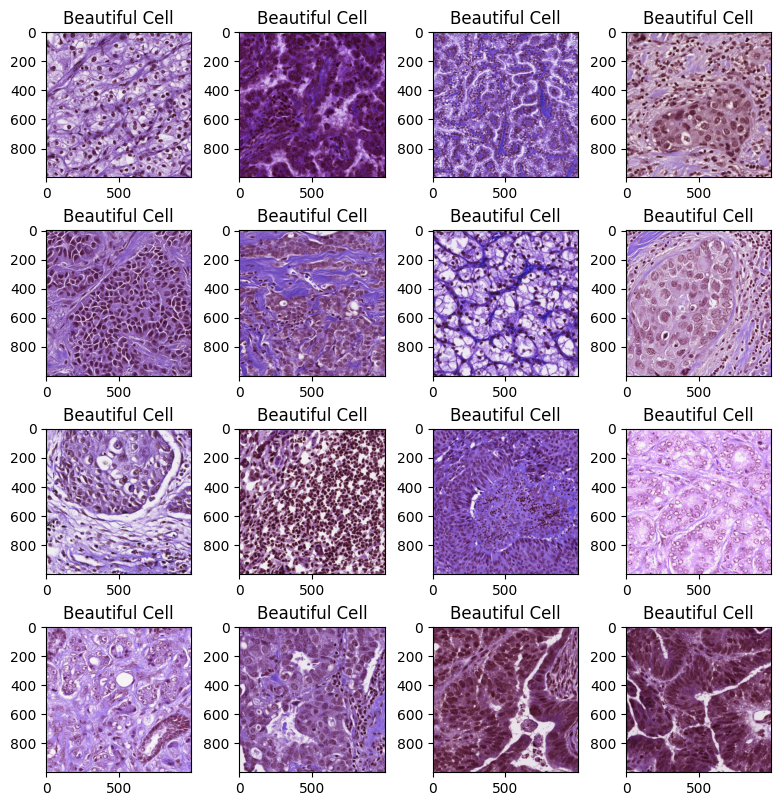

In [6]:
fig = plt.figure(figsize =(8, 8))
rows, cols = 4, 4
for i in range(rows*cols):
  plt.subplot(rows, cols, i+1)
  fig.tight_layout(pad=0.5)
  image = image_files[i]
  plt.imshow(image)
  plt.title("Beautiful Cell")


In [8]:
from matplotlib.patches import Polygon

ANNOTATIONS_PATH = './Cell_Seg_Count-CMU/Annotations'
annotation_files = []
for each_file in os.listdir(ANNOTATIONS_PATH):
  each_file = os.path.join(ANNOTATIONS_PATH, each_file)
  annotation_files.append(each_file)

len(annotation_files)

30

In [9]:
annotation_files[0]

'./Cell_Seg_Count-CMU/Annotations/TCGA-AR-A1AK-01Z-00-DX1.xml'

In [ ]:
# try_annot = ['/content/Cell_Seg_Count-CMU/Annotations/TCGA-RD-A8N9-01A-01-TS1.xml']
# try_image = ['/content/Cell_Seg_Count-CMU/Tissue Images/TCGA-RD-A8N9-01A-01-TS1.tif']

# for xml_file, image_file in zip(try_annot, try_image):

for xml_file, image_file in zip(annotation_files, image_files):


  tree = ET.parse(xml_file)
  root = tree.getroot()

  # Read the image
  # image = Image.open(image_file)
  ### since image_file is actually a numpy array, you dont need to open it. we can directly just use it.
  image = image_file

  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(6, 6))

  # Display the image
  ax.imshow(image)
  annotations_number = 0
  # Iterate through each Annotation in the XML
  for annotation in root.findall('Annotation'):
      for region in annotation.findall('.//Region'):
          annotations_number += 1
          vertices = []
          for vertex in region.findall('.//Vertex'):
              x = float(vertex.get('X'))
              y = float(vertex.get('Y'))
              vertices.append((x, y))
          polygon = Polygon(vertices, edgecolor='g', facecolor='none', linewidth=1)
          ax.add_patch(polygon)

plt.title('Image with Annotations')
plt.show()

#Setup Configs


In [ ]:
EPOCHS = 25
IMG_SIZE = ...
BATCH_SIZE = 1
LR = ...

ENCODER = 'timm-efficientnet-b7'
WEIGHTS = 'imagenet'

In [ ]:
! git push

#Load Data - DataLoader


In [ ]:
from torch.utils.data import DataLoader

#Segmentation Model

In [4]:
import requests
from pathlib import Path

if Path("Segmentation_Model.py").is_file():
  print("Segmentation_Model.py already exists, skipping download")
else:
  print("Downloading Segmentation_Model.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/willxxy/Cell_Seg_Count-CMU/main/Segmentation_Model.py")
  with open("unet_model.py", "wb") as f:
    f.write(request.content)

In [7]:
from Segmentation_Model import CellSegmenter_fn



SyntaxError: invalid syntax (Segmentation_Model.py, line 6)